# 03 — Bias Correction Model (Robust: sparse-safe + impute + de-collinear)

This notebook is designed to be robust for large, sparse covariate sets:

- Loads `../processed_data/weekly_with_covariates.csv`
- Target: `EcoCntr_weekly_SUM`
- Predictors: `SUM_total_trip_count` + all other covariates (excluding IDs/dates)
- Drops covariate **columns** with > **80% NaN** (too sparse)
- Train/test split, then **impute** remaining NaNs with **train means** (no leakage)
- Removes **constant** and **duplicate** columns to reduce multicollinearity
- Fits OLS (HC3 robust SEs), evaluates, and exports predictions + metrics


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

pd.set_option("display.max_columns", 200)

## 1) Load merged weekly dataset

In [2]:
# Path to merged CSV
DATA_PATH = "../processed_data/weekly_with_covariates.csv"
data = pd.read_csv(DATA_PATH, parse_dates=["week_start"], low_memory=False)
print("Loaded:", data.shape)

# Sanity checks
assert "EcoCntr_weekly_SUM" in data.columns, "EcoCntr_weekly_SUM not found."
assert "SUM_total_trip_count" in data.columns, "SUM_total_trip_count not found."

data.head()

Loaded: (3377, 278)


,GRID_ID.1,STARTweek_stravaDATE_cast,GRID_ID,ENDweek_stravaDATE_cast,SUM_total_trip_count,EcoCntr_weekly_SUM,MAX_slopePct,STARTweek_Time,HEXid_weekID,HEXid_WeekID,ENDweek_Time,week_id,week_start,_GRID_JOIN_,OBJECTID *,Shape *,SOURCE_ID,GRID_ID_cov,slopePct,TrailCounter,SqMeters,ASOSID,AR_asosID_hexID,Slope_10m_MEAN,OBJECTID,GRID_ID.1_cov,TIMESTEP_stravaDATE_cast,STARTTIME_stravaDATE_cast,ENDTIME_stravaDATE_cast,SUM_EcoCounter_WeeklyAggregation,SUM_total_trip_count_cov,SUM_ride_count,MAX_activity_type,MAX_slopePct_cov,SUM_forward_people_count,SUM_reverse_people_count,SUM_forward_commute_trip_count,SUM_reverse_commute_trip_count,SUM_forward_leisure_trip_count,SUM_reverse_leisure_trip_count,SUM_ebike_ride_count,SUM_forward_morning_trip_count,SUM_reverse_morning_trip_count,SUM_forward_midday_trip_count,SUM_reverse_midday_trip_count,SUM_forward_evening_trip_count,SUM_reverse_evening_trip_count,SUM_forward_male_people_count,SUM_reverse_male_people_count,SUM_forward_female_people_count,SUM_reverse_female_people_count,SUM_forward_18_34_people_count,SUM_reverse_18_34_people_count,SUM_forward_35_54_people_count,SUM_reverse_35_54_people_count,SUM_forward_55_64_people_count,SUM_reverse_55_64_people_count,MIN_slopePct,hexid_weekid_join,ASOS_ID,HexIDstation,ASOS ID WeekID Join,asosID_encodeSTEP,TIMESTEP_weekID,STARTTIME_Weekday,ENDTIME_Weekday,station,MAX_max_temp_f,MIN_min_temp_f,MAX_max_dewpoint_f,MIN_min_dewpoint_f,SUM_precip_in,MEAN_avg_wind_speed_kts,MEAN_avg_wind_drct,MIN_min_rh,MEAN_avg_rh,MAX_max_rh,SUM_snow_in,MIN_min_feel,MEAN_avg_feel,MAX_max_feel,MAX_max_wind_speed_kts,MAX_max_wind_gust_kts,MAX_climo_high_f,MIN_climo_low_f,SUM_climo_precip_in,Location of Ecocounter,COUNT,MEAN_forward_average_speed_meters_per_second,MEAN_reverse_average_speed_meters_per_second,SUM_forward_overnight_trip_count,SUM_reverse_overnight_trip_count,SUM_forward_unspecified_people_count,SUM_reverse_unspecified_people_count,SUM_forward_65_plus_people_count,SUM_reverse_65_plus_people_count,OBJECTID.1,HEX GRID_ID,Slope Pct Category,Slope MAXpct,...,2029 Other Race Population,2029 Other Race Population: Percent,2029 Diversity Index,2022 Pop 25+: HS Diploma (ACS 5-Yr),2022 Pop 25+: HS Diploma (ACS 5-Yr): Percent,2022 Pop 25+: Some College (ACS 5-Yr),2022 Pop 25+: Some College (ACS 5-Yr): Percent,2022 Pop 25+: Assoc Degree (ACS 5-Yr),2022 Pop 25+: Assoc Degree (ACS 5-Yr): Percent,2022 Pop 25+: Bach Degree (ACS 5-Yr),2022 Pop 25+: Bach Degree (ACS 5-Yr): Percent,2022 Pop 25+: Master`s Deg (ACS 5-Yr),2022 Pop 25+: Master`s Deg (ACS 5-Yr): Percent,2022 Pop 25+: Prof Sch Deg (ACS 5-Yr),2022 Pop 25+: Prof Sch Deg (ACS 5-Yr): Percent,2022 Pop 25+: Doctorate (ACS 5-Yr),2022 Pop 25+: Doctorate (ACS 5-Yr): Percent,2024 Pop Age 25+: High School Diploma,2024 Pop Age 25+: High School Diploma: Percent,2024 Pop Age 25+: GED,2024 Pop Age 25+: GED: Percent,2020 Total Population,2024 Total Population,2024 Population Density,2022 Civilian Pop 18+: Veteran (ACS 5-Yr),2022 Civilian Pop 18+: Veteran (ACS 5-Yr): Percent,2022 Civilian Pop 18+: Nonveteran (ACS 5-Yr),2022 Civilian Pop 18+: Nonveteran (ACS 5-Yr): Percent,2022 Workers 16+: Bicycle (ACS 5-Yr),2022 Workers 16+: Bicycle (ACS 5-Yr): Percent,2022 Workers 16+: Walked (ACS 5-Yr),2022 Workers 16+: Walked (ACS 5-Yr): Percent,2022 Commute to Work: 15-19 Min (ACS 5-Yr),2022 Commute to Work: 15-19 Min (ACS 5-Yr): Percent,2022 Commute to Work: 10-14 Min (ACS 5-Yr),2022 Commute to Work: 10-14 Min (ACS 5-Yr): Percent,2022 Commute to Work: 5-9 Min (ACS 5-Yr),2022 Commute to Work: 5-9 Min (ACS 5-Yr): Percent,2022 Commute to Work: <5 Min (ACS 5-Yr),2022 Commute to Work: <5 Min (ACS 5-Yr): Percent,2022 Avg Commute to Work (ACS 5-Yr),2024 Median Age,2024 Median Age: Index,2024 Senior Population,2024 Senior Population: Percent,2020 Multiple Races Pop 35-39,2020 Multiple Races Pop 35-39: Percent,2024 Population Age 0-4,2024 Population Age 0-4: Percent,2022 Poverty Index (ACS 5-Yr),2022 HHs: Inc Below Poverty Level (ACS 5-Yr),2022 HHs: Inc Bel

## 2) Build predictors

In [3]:
# Exclude ID/date/geometry columns
core_cols = [
    "week_id", "week_start", "EcoCntr_weekly_SUM",
    "SUM_total_trip_count", "GRID_ID", "GRID_ID.1",
    "HEXid_WeekID", "HEXid_weekID", "STARTweek_Time", "ENDweek_Time",
    "STARTweek_stravaDATE_cast", "ENDweek_stravaDATE_cast",
    "_GRID_JOIN_", "OBJECTID *", "Shape *", "OBJECTID", "Shape"
]

predictors = ["SUM_total_trip_count"] + [c for c in data.columns if c not in core_cols]

# Coerce numerics (non-numeric -> NaN)
for c in predictors:
    data[c] = pd.to_numeric(data[c], errors="coerce")

# y and X (minimal row filter: target + main predictor must exist)
y = pd.to_numeric(data["EcoCntr_weekly_SUM"], errors="coerce")
X = data[predictors].copy()
mask = (~y.isna()) & (~X["SUM_total_trip_count"].isna())
X = X.loc[mask].copy()
y = y.loc[mask].copy()

print("Rows after minimal filter:", X.shape[0])
print("Predictor count (incl. Strava):", len(predictors))

Rows after minimal filter: 3377
Predictor count (incl. Strava): 263


## 3) Drop very sparse columns (>80% NaN)

In [4]:
# Compute NaN fraction per column, drop columns with >80% NaN
nan_frac = X.isna().mean()
keep_cols = nan_frac[nan_frac <= 0.80].index.tolist()
X = X[keep_cols].copy()
print("Predictors retained after sparsity filter:", len(keep_cols))

Predictors retained after sparsity filter: 228


## 4) Train/test split + mean imputation (fit on train)

In [5]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Imputer fit on train only (no leakage)
imputer = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print("Train/Test shapes post-impute:", X_train_imp.shape, X_test_imp.shape)

Train/Test shapes post-impute: (2701, 228) (676, 228)


## 5) Remove constant and duplicate columns (reduce multicollinearity)

In [6]:
# Drop constant columns
nonconst_cols = X_train_imp.columns[X_train_imp.nunique() > 1]
X_train_imp = X_train_imp[nonconst_cols]
X_test_imp  = X_test_imp[nonconst_cols]

# Drop duplicate columns
X_train_imp = X_train_imp.loc[:, ~X_train_imp.T.duplicated()]
# Align test to train columns
X_test_imp  = X_test_imp[X_train_imp.columns]

print(f"Predictors retained after collinearity filter: {len(X_train_imp.columns)}")

Predictors retained after collinearity filter: 222


## 6) Fit OLS (HC3) and evaluate

In [7]:
# Add constant
X_train_const = sm.add_constant(X_train_imp, has_constant="add")
X_test_const  = sm.add_constant(X_test_imp,  has_constant="add")

# Fit OLS
model = sm.OLS(y_train, X_train_const).fit(cov_type="HC3")

# Predict & evaluate (manual RMSE for older sklearns)
y_pred = model.predict(X_test_const)
y_true = pd.Series(y_test).astype(float)
y_hat  = pd.Series(y_pred).astype(float)
mask_eval = y_true.notna() & y_hat.notna()
y_true = y_true[mask_eval]
y_hat  = y_hat[mask_eval]

mse  = mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_hat)

print(model.summary())
print({"rmse_test": rmse, "r2_test": r2})

                            OLS Regression Results                            
Dep. Variable:     EcoCntr_weekly_SUM   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     728.0
Date:                Wed, 06 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:24:50   Log-Likelihood:                -23860.
No. Observations:                2701   AIC:                         4.775e+04
Df Residuals:                    2687   BIC:                         4.783e+04
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

/srv/conda/envs/notebook/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 222, but rank is 14
  warnings.warn('covariance of constraints does not have full '


## 7) Predict for all rows and export artifacts

In [8]:
from pathlib import Path

# Impute all rows and apply same column filtering
X_all = data[[c for c in X.columns]].copy()
for c in X_all.columns:
    X_all[c] = pd.to_numeric(X_all[c], errors="coerce")
X_all_imp = pd.DataFrame(imputer.transform(X_all), columns=X_all.columns, index=X_all.index)

# Apply same non-constant and duplicate filtering as train
X_all_imp = X_all_imp[X_train_imp.columns]

X_all_const = sm.add_constant(X_all_imp, has_constant="add")
pred_all = model.predict(X_all_const)

out = data.copy()
out["predicted_eco_from_model"] = pred_all

# Save outputs
out_dir = Path("../processed_data")
out_dir.mkdir(exist_ok=True)
pred_path = out_dir / "weekly_predictions_with_covariates.csv"
meta_path = out_dir / "model_metrics.txt"

keep_cols = ["week_id", "week_start", "EcoCntr_weekly_SUM", "SUM_total_trip_count", "predicted_eco_from_model"]
for k in ["GRID_ID", "GRID_ID.1", "HEXid_WeekID", "HEXid_weekID"]:
    if k in out.columns and k not in keep_cols:
        keep_cols.append(k)

out[keep_cols].to_csv(pred_path, index=False)

with open(meta_path, "w") as f:
    f.write(model.summary().as_text())
    f.write(f"\nRMSE_test: {rmse:.4f}\nR2_test: {r2:.4f}\n")

pred_path, meta_path

(PosixPath('../processed_data/weekly_predictions_with_covariates.csv'),
 PosixPath('../processed_data/model_metrics.txt'))

## 8) Quick diagnostic plot

PosixPath('../figures/obs_vs_pred_test.png')

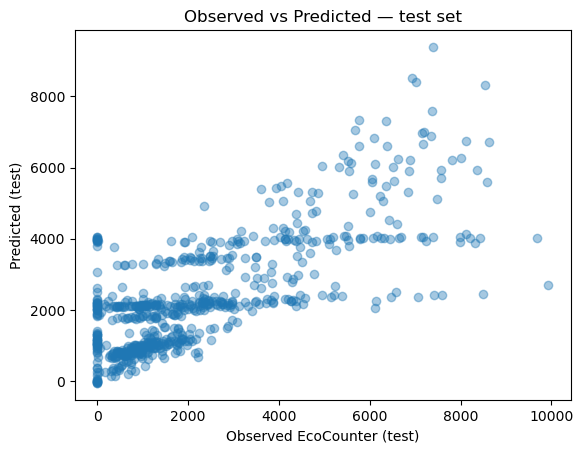

In [9]:
plt.figure()
plt.scatter(y_true, y_hat, alpha=0.4)
plt.xlabel("Observed EcoCounter (test)")
plt.ylabel("Predicted (test)")
plt.title("Observed vs Predicted — test set")
from pathlib import Path
plot_path = Path("../figures/obs_vs_pred_test.png")
plot_path.parent.mkdir(exist_ok=True)
plt.savefig(plot_path, bbox_inches="tight")
plot_path